In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import time
from datetime import datetime
import single_node_profiles_cpp as snp
import profiler
import numpy as np
from optimizer import BruteForceOptimizer, GreedyOptimizer
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


In [14]:
profs = snp.load_single_node_profiles()

In [15]:
node_profs = {name : profiler.NodeProfile(name, profs[name]) for name in profs.keys()}

In [5]:
node_profs

{'alexnet': <profiler.NodeProfile at 0x10ee31978>,
 'inception': <profiler.NodeProfile at 0x1527b09860>,
 'res152': <profiler.NodeProfile at 0x10fe46588>,
 'res50': <profiler.NodeProfile at 0x10ee439b0>,
 'tf-kernel-svm': <profiler.NodeProfile at 0x1527b091d0>,
 'tf-log-reg': <profiler.NodeProfile at 0x1527b09828>,
 'tf-resnet-feats': <profiler.NodeProfile at 0x110fb3b00>}

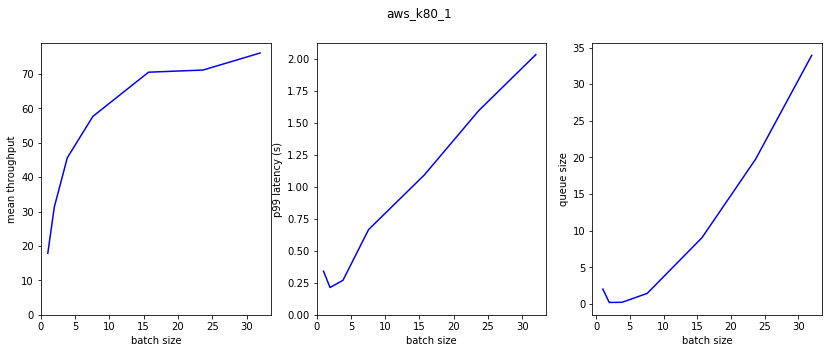

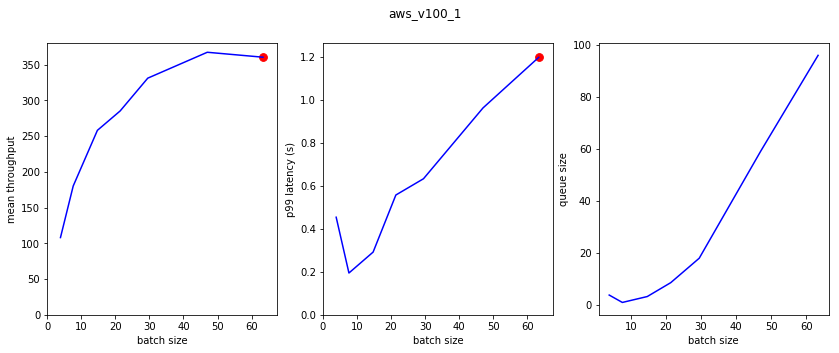

In [16]:
node_profs["inception"].plot_profile()

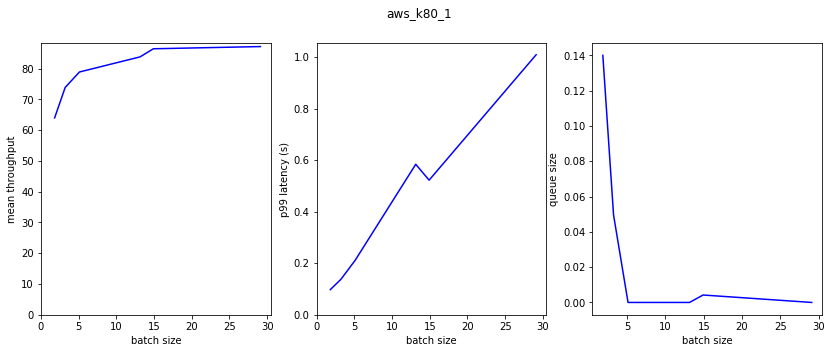

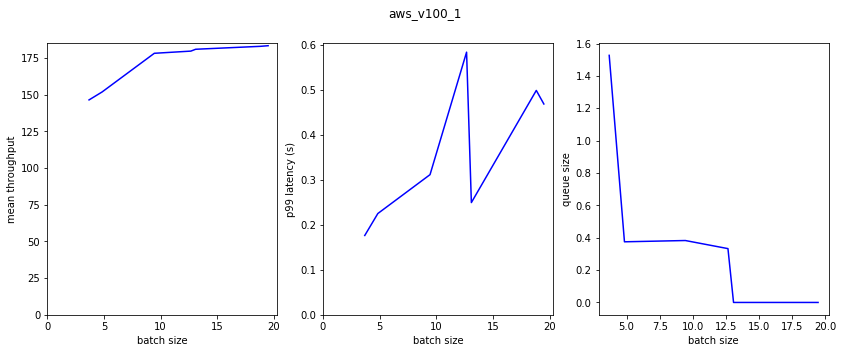

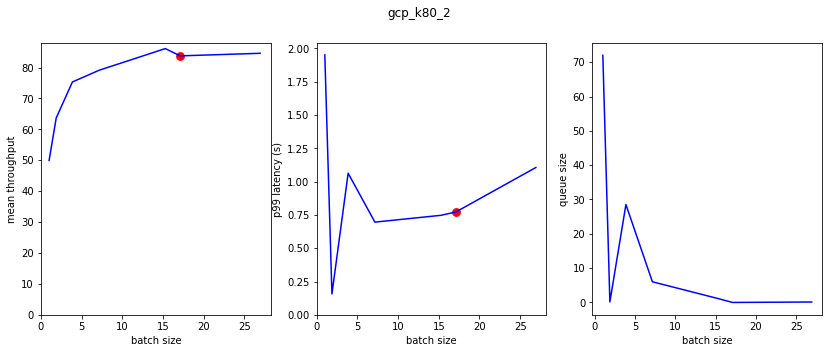

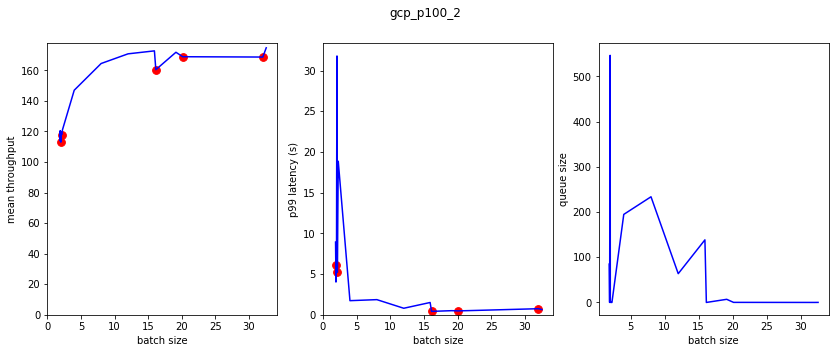

In [21]:
node_profs["res50"].plot_profile()

In [ ]:
name = "/Users/crankshaw/clipper-project/model-comp-project/plots-model-comp-paper/results_cpp_benchmarker/single_model_profs/pytorch-res50"
summaries = {}
for f in os.listdir(name):
    if "p100" in f:
        with open(os.path.join(name, f), "r") as g:
            summaries[f] = json.load(g)["summary_metrics"]